## Authorship Attribution Using Explainable Machine Learning Techniques

**Problem Statement**

With the rapid growth of digital text content, determining the true authorship of a document has become increasingly important in areas such as academic integrity, plagiarism detection, forensic linguistics, and copyright verification. Traditional authorship detection systems rely on complex machine learning models that often behave as black boxes, providing predictions without explaining the reasoning behind them.

This lack of interpretability raises concerns regarding trust, fairness, and accountability, especially in sensitive domains such as legal investigations and academic evaluations. Therefore, there is a strong need for an Explainable AI (XAI)-based authorship detection system that not only accurately predicts the author of a given text but also clearly explains which textual features influenced the prediction.

This project aims to address this challenge by developing an end-to-end authorship detection system using Project Gutenberg texts, combined with Explainable AI techniques to make the predictions transparent and interpretable.

**Objectives**

The main objectives of this project are:
- To build an automated authorship detection system using Natural Language Processing (NLP) and machine learning techniques.
- To analyze writing styles (stylometry) of different authors using lexical and character-level features.
- To train and evaluate supervised machine learning models for multi-class authorship classification.
- To integrate Explainable AI (XAI) techniques such as LIME and SHAP to interpret model predictions.
- To visualize influential words and stylistic patterns responsible for authorship decisions.
- To develop an interactive Streamlit web application that allows users to input text and view both predictions and explanations.
- To improve trust and transparency in authorship attribution systems.

**Dataset Description**

**Dataset Name:** Project Gutenberg Authorship Attribution Dataset

**Dataset Source:** Project Gutenberg – Public Domain Literary Texts

**Dataset Format**
**Metadata:** CSV file

**Text Data:** Plain text (.txt) files

**Dataset Characteristics**

- Contains literary works from multiple authors

- All texts are public domain

- Texts vary in length and writing style

- Suitable for stylometric and NLP-based authorship analysis

**Purpose of Dataset Usage:** The dataset is used to learn author-specific writing patterns, such as vocabulary usage, phrase construction, and stylistic consistency.

**Dataset Column Description**

## Metadata Description

The metadata file (`gutenberg_metadata.csv`) provides descriptive information about each literary work included in the Project Gutenberg dataset. This metadata is used for dataset organization, reference, and validation, and is **not used directly for model training**.

| Column Name | Data Type | Description |
|------------|----------|-------------|
| **Title** | String | The title of the literary work or book available in Project Gutenberg |
| **Author** | String | Name of the author who wrote the literary work; used as the class label for authorship attribution |
| **Link** | String (URL) | Direct URL link to the book’s page on the Project Gutenberg website |
| **Bookshelf** | String | The thematic category or bookshelf under which the book is classified in Project Gutenberg |

### Notes
- Each row in the metadata corresponds to one literary work.
- The **Author** column represents the target variable for supervised learning.
- The **Link** column is used only for reference and verification purposes.
- The **Bookshelf** column can optionally be used for exploratory analysis but is not part of the authorship prediction pipeline.


## Data Loading

In [68]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import re
import string

# ===============================
# ML & NLP
# ===============================
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# ===============================
# EXPLAINABLE AI (XAI)
# ===============================
import shap

# ===============================
# VISUALIZATION
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# GENERAL UTILITIES
# ===============================
from tqdm import tqdm
tqdm.pandas()

print("✅ All libraries imported successfully")


✅ All libraries imported successfully


In [2]:
meta = pd.read_csv(r"gutenberg_metadata.csv")
meta

,Title,Author,Link,Bookshelf
0,The Extermination of the American Bison,William T. Hornaday,http://www.gutenberg.org/ebooks/17748,Animal
1,Deadfalls and Snares,A. R. Harding,http://www.gutenberg.org/ebooks/34110,Animal
2,Artistic Anatomy of Animals,Édouard Cuyer,http://www.gutenberg.org/ebooks/38315,Animal
3,"Birds, Illustrated","Color Photography, Vol. 1, No. 1 Various",http://www.gutenberg.org/ebooks/30221,Animal
4,On Snake-Poison: Its Action and Its Antidote,A. Mueller,http://www.gutenberg.org/ebooks/32947,Animal
...,...,...,...,...
15326,Psichopath,Randall Garrett,http://www.gutenberg.org/ebooks/30304,NaN
15327,Poisoned Air,S. P. Meek,http://www.gutenberg.org/ebooks/29069,NaN
15328,Cry from a Far Planet,Tom Godwin,http://www.gutenberg.org/ebooks/23799,NaN
15329,Spies Die Hard!,Arnold Marmor,http://www.gutenberg.org/ebooks/30383,NaN


In [3]:
df = pd.read_csv(r"authorship_dataset.csv")
df

,author,text,author_label
0,Unknown Author,The Old Testament of the King James Version of...,0
1,Unknown Author,"creepeth upon the earth, wherein there is life...",0
2,Unknown Author,"unto the woman, Ye shall not surely die: 3:5 F...",0
3,Unknown Author,"and it came to pass, when they were in the fie...",0
4,Unknown Author,And all the days of Jared were nine hundred si...,0
...,...,...,...
18410,Unknown Author,wasn't likely Joe could manage to escape him a...,0
18411,Unknown Author,to get even with McNutt. I think our chances a...,0
18412,Unknown Author,"approached it from the rear before, so it took...",0
18413,Unknown Author,"comprising the spacious right wing, and when a...",0


Filter the books with no author and text

In [8]:
meta = meta[
    meta["Author"].notna() &
    meta["Link"].notna()
]

print("After filtering:", meta.shape)
meta.head()

After filtering: (14135, 4)


,Title,Author,Link,Bookshelf
0,The Extermination of the American Bison,William T. Hornaday,http://www.gutenberg.org/ebooks/17748,Animal
1,Deadfalls and Snares,A. R. Harding,http://www.gutenberg.org/ebooks/34110,Animal
2,Artistic Anatomy of Animals,Édouard Cuyer,http://www.gutenberg.org/ebooks/38315,Animal
3,"Birds, Illustrated","Color Photography, Vol. 1, No. 1 Various",http://www.gutenberg.org/ebooks/30221,Animal
4,On Snake-Poison: Its Action and Its Antidote,A. Mueller,http://www.gutenberg.org/ebooks/32947,Animal


To avoid model overload,memory usage and time complexities we are going with minimal data size

In [9]:
meta = meta.head(60)
print("Using rows:", meta.shape[0])

Using rows: 60


**Downloading Book Texts**

In [10]:
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen

def get_plain_text(link):
    try:
        page = requests.get(link, timeout=10)
        soup = BeautifulSoup(page.content, "html.parser")
        txt_link = soup.find("a", string="Plain Text UTF-8")
        if not txt_link:
            return None

        txt_url = "https://www.gutenberg.org" + txt_link["href"]
        text = urlopen(txt_url).read().decode("utf-8", errors="ignore")
        return text

    except:
        return None

In [11]:
rows = []

for _, row in meta.iterrows():
    text = get_plain_text(row["Link"])

    if not text or len(text) < 5000:
        continue

    rows.append({
        "title": row["Title"],
        "author": row["Author"],
        "text": text
    })

    print("✅", row["Author"])

df = pd.DataFrame(rows)

✅ William T. Hornaday
✅ A. R. Harding
✅ Édouard Cuyer
✅ Color Photography, Vol. 1, No. 1 Various
✅ A. Mueller
✅ E. N. Woodcock
✅ Frank M. Chapman
✅ Lucas, Shinn, Smallwood, and Whitney
✅ William T. Hornaday
✅ A. R. Harding
✅ W. H. Hudson
✅ De Gubernatis
✅ G. Murray Levick
✅ William S. Furneaux
✅ Chester A. Reed
✅ Grinnell et al.
✅ Ernest Thompson Seton
✅ Max C. Thompson
✅ Sir James Emerson Tennent
✅ Robert Armitage Sterndale
✅ Clarence Moores Weed
✅ Frederic A. Lucas
✅ Elmer Harry Kreps
✅ Edward Saunders
✅ Jack London
✅ Ouida
✅ Harrison Weir
✅ Albert Payson Terhune
✅ Arthur Scott Bailey
✅ Edith Wharton
✅ Edward Jesse
✅ Helen Hunt Jackson
✅ Dinks, W. N. Hutchinson, and Edward Mayhew
✅ Oliver Hartley
✅ Charles Darwin
✅ Alfred Elwes
✅ Richard Lamb Allen
✅ Mrs. Leslie Williams
✅ Maurice Maeterlinck
✅ J. Earl Clauson
✅ E. Nesbit
✅ Charles Darwin
✅ Oliver Herford
✅ Allen Christian Smith
✅ Nathaniel Southgate Shaler
✅ A. J. Dawson
✅ Esther Birdsall Darling
✅ Robert Jennings
✅ Henny Kindermann

In [12]:
print("Total books downloaded:", df.shape[0])
print("\nBooks per author:\n")
print(df["author"].value_counts())

Total books downloaded: 60

Books per author:

author
William T. Hornaday                           3
A. R. Harding                                 2
Édouard Cuyer                                 2
De Gubernatis                                 2
Lucas, Shinn, Smallwood, and Whitney          2
Ernest Thompson Seton                         2
Frederic A. Lucas                             2
Charles Darwin                                2
E. N. Woodcock                                1
Frank M. Chapman                              1
Color Photography, Vol. 1, No. 1 Various      1
G. Murray Levick                              1
William S. Furneaux                           1
Chester A. Reed                               1
Grinnell et al.                               1
Max C. Thompson                               1
Sir James Emerson Tennent                     1
W. H. Hudson                                  1
A. Mueller                                    1
Clarence Moores Weed              

Filtering Authors - Authorship attribution requires multiple samples per author to learn stylistic patterns. Authors with only one text were excluded to avoid overfitting and improve generalization.

In [13]:
author_counts = df["author"].value_counts()
valid_authors = author_counts[author_counts >= 2].index

df = df[df["author"].isin(valid_authors)]

print("Authors:", df["author"].nunique())
print(df["author"].value_counts())

Authors: 8
author
William T. Hornaday                     3
A. R. Harding                           2
Édouard Cuyer                           2
Lucas, Shinn, Smallwood, and Whitney    2
De Gubernatis                           2
Ernest Thompson Seton                   2
Frederic A. Lucas                       2
Charles Darwin                          2
Name: count, dtype: int64


## Data Preprocessing

In [15]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\n+", " ", text)
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

In [16]:
df = df.drop_duplicates(subset="clean_text")
print("After deduplication:", df.shape)

After deduplication: (11, 4)


## Exploratory Data Analysis

In [17]:
print("Total books:", df.shape[0])
print("Total authors:", df["author"].nunique())

Total books: 11
Total authors: 8


In [18]:
df["author"].value_counts()

author
William T. Hornaday                     2
A. R. Harding                           2
Charles Darwin                          2
Édouard Cuyer                           1
Lucas, Shinn, Smallwood, and Whitney    1
De Gubernatis                           1
Ernest Thompson Seton                   1
Frederic A. Lucas                       1
Name: count, dtype: int64

In [19]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
df["text_length"].describe()

count        11.000000
mean     123962.181818
std      109065.485050
min       40770.000000
25%       50913.500000
50%       97763.000000
75%      164392.000000
max      409224.000000
Name: text_length, dtype: float64

Interpretation

- Large text lengths → good for chunking
- Confirms books are long enough to generate multiple samples

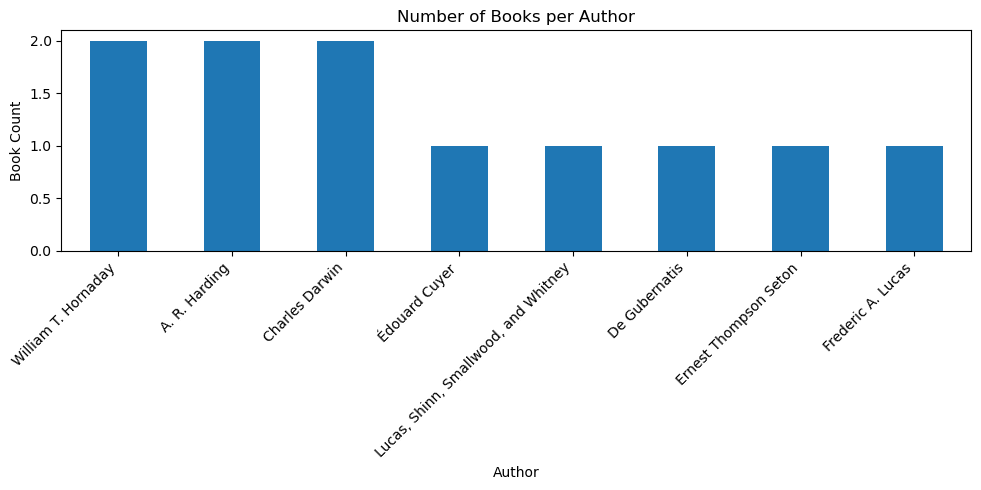

In [21]:
import matplotlib.pyplot as plt

author_counts = df["author"].value_counts()

plt.figure(figsize=(10,5))
author_counts.plot(kind="bar")
plt.title("Number of Books per Author")
plt.xlabel("Author")
plt.ylabel("Book Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

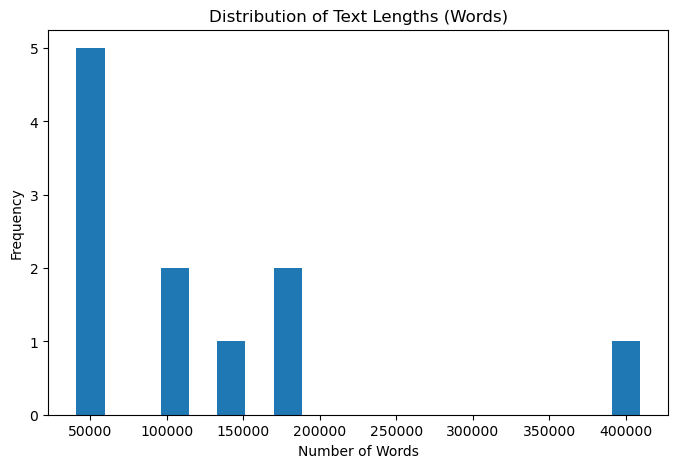

In [22]:
plt.figure(figsize=(8,5))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Text Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

<Figure size 1000x500 with 0 Axes>

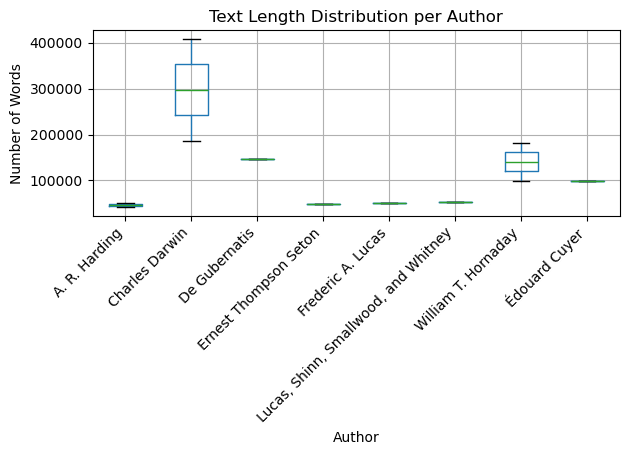

In [23]:
plt.figure(figsize=(10,5))
df.boxplot(column="text_length", by="author")
plt.title("Text Length Distribution per Author")
plt.suptitle("")
plt.xlabel("Author")
plt.ylabel("Number of Words")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

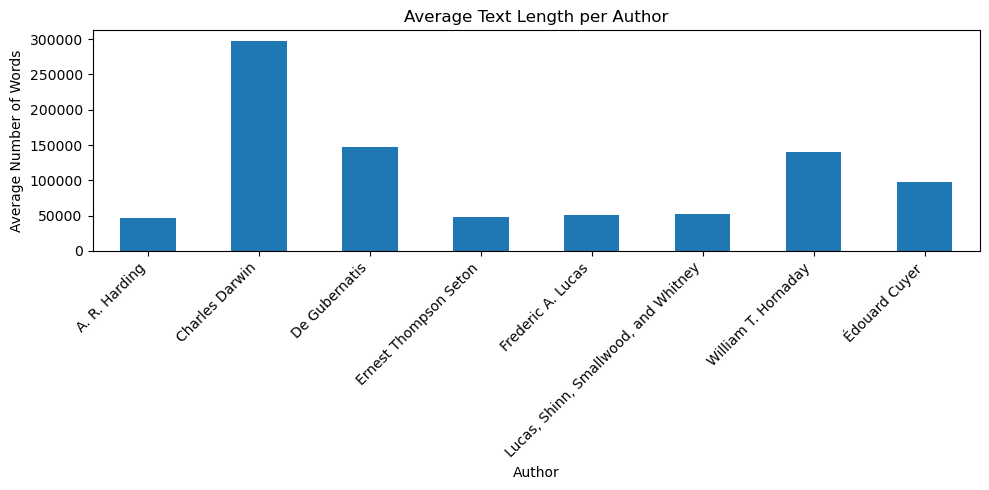

In [24]:
avg_length = df.groupby("author")["text_length"].mean()

plt.figure(figsize=(10,5))
avg_length.plot(kind="bar")
plt.title("Average Text Length per Author")
plt.xlabel("Author")
plt.ylabel("Average Number of Words")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

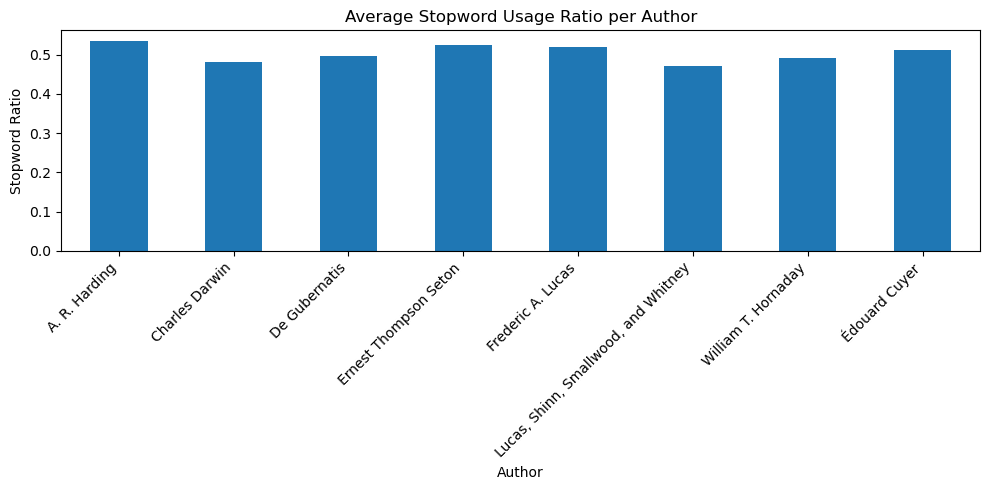

In [29]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def stopword_ratio(text):
    words = text.split()
    stopwords = [w for w in words if w in ENGLISH_STOP_WORDS]
    return len(stopwords) / max(len(words), 1)

df["stopword_ratio"] = df["clean_text"].apply(stopword_ratio)

stop_ratio = df.groupby("author")["stopword_ratio"].mean()

plt.figure(figsize=(10,5))
stop_ratio.plot(kind="bar")
plt.title("Average Stopword Usage Ratio per Author")
plt.xlabel("Author")
plt.ylabel("Stopword Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Text Chunking

In [30]:
def chunk_text(text, chunk_size=1000, overlap=200):
    words = text.split()
    chunks = []
    i = 0

    while i < len(words):
        chunk = words[i:i + chunk_size]
        if len(chunk) >= 300:   # discard very small chunks
            chunks.append(" ".join(chunk))
        i += chunk_size - overlap

    return chunks

In [31]:
records = []

for _, row in df.iterrows():
    chunks = chunk_text(row["clean_text"])
    for ch in chunks:
        records.append({
            "author": row["author"],
            "text": ch
        })

chunk_df = pd.DataFrame(records)
print("Total chunks created:", chunk_df.shape[0])

Total chunks created: 1706


In [32]:
chunk_df["author"].value_counts()

author
Charles Darwin                          745
William T. Hornaday                     352
De Gubernatis                           184
Édouard Cuyer                           122
A. R. Harding                           115
Lucas, Shinn, Smallwood, and Whitney     65
Frederic A. Lucas                        63
Ernest Thompson Seton                    60
Name: count, dtype: int64

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
chunk_df["author_label"] = le.fit_transform(chunk_df["author"])

print("Number of authors:", len(le.classes_))

Number of authors: 8


In [40]:
chunk_df.to_csv("authorship_chunked_dataset.csv", index=False)
print("authorship_chunked_dataset.csv saved")

authorship_chunked_dataset.csv saved


Since authorship attribution relies on stylistic patterns, long documents were split into overlapping text chunks to generate multiple training samples per author and improve model generalization

## Baseline Authorship Model

In [35]:
import pandas as pd

chunk_df = pd.read_csv("authorship_chunked_dataset.csv")

X = chunk_df["text"]
y = chunk_df["author_label"]

print("Samples:", X.shape[0])
print("Authors:", chunk_df["author"].nunique())

Samples: 1706
Authors: 8


In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=30000,
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])

In [39]:
model.fit(x_train, y_train)
print("Baseline model trained")

Baseline model trained


In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9502923976608187

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        23
           1       0.99      0.98      0.98       149
           2       1.00      0.97      0.99        37
           3       1.00      0.75      0.86        12
           4       1.00      0.77      0.87        13
           5       1.00      0.85      0.92        13
           6       0.88      1.00      0.93        71
           7       1.00      0.96      0.98        24

    accuracy                           0.95       342
   macro avg       0.96      0.89      0.92       342
weighted avg       0.95      0.95      0.95       342



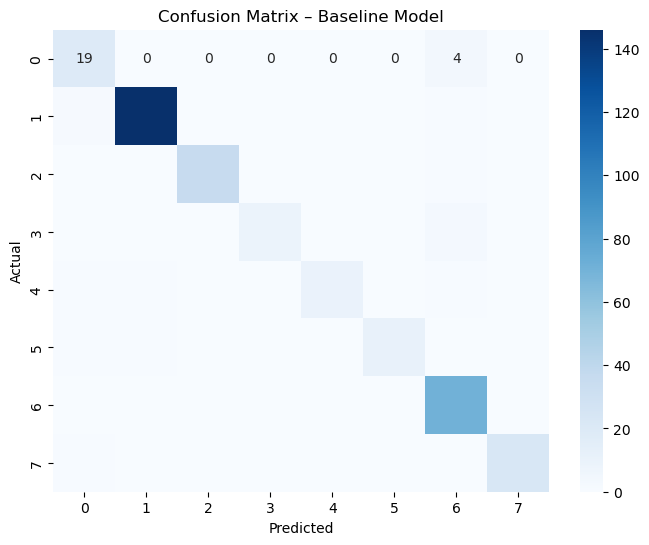

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Baseline Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

A TF-IDF based Logistic Regression model was trained as a baseline for authorship attribution. The model captures lexical and phrase-level stylistic features and provides an interpretable foundation for explainable AI analysis.

## Explainable AI(SHAP) for Authorship

In [71]:
import shap

# Extract trained components
vectorizer = model.named_steps["tfidf"]
classifier = model.named_steps["clf"]

In [70]:
x_train_tfidf = vectorizer.transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [46]:
explainer = shap.LinearExplainer(classifier,x_train_tfidf,feature_perturbation="interventional")

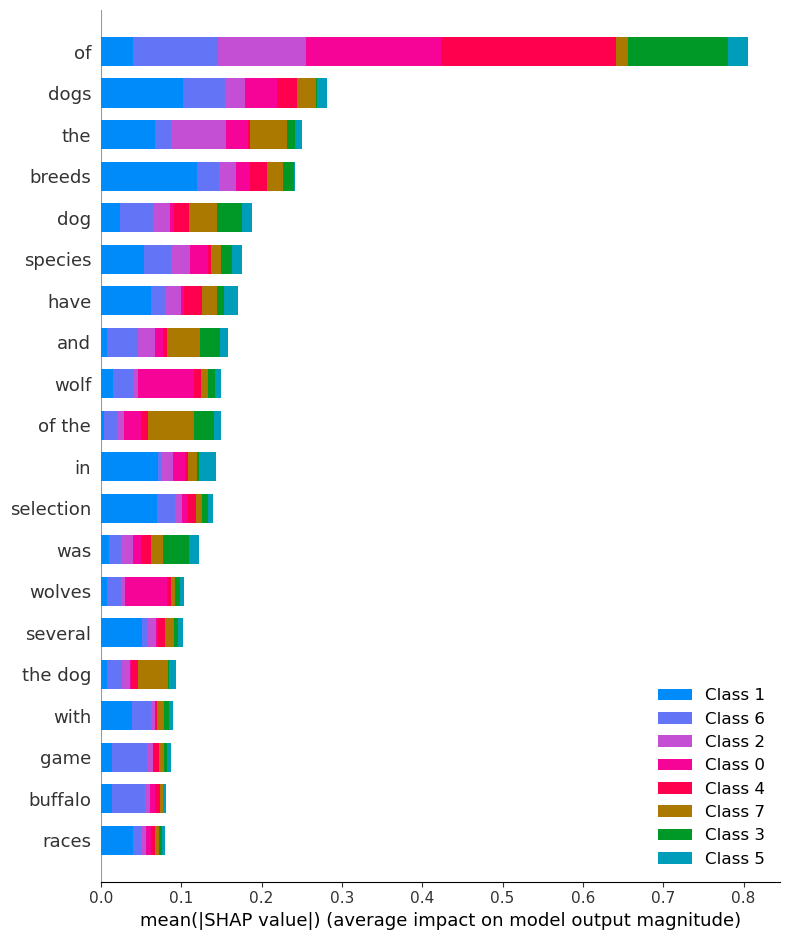

In [49]:
# Pick one test sample
sample_id = 0

shap_values = explainer.shap_values(x_test_tfidf[sample_id])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Visual explanation
shap.summary_plot(
    shap_values,
    features=x_test_tfidf[sample_id],
    feature_names=feature_names,
    plot_type="bar"
)

What this shows
* Top words that influenced the prediction
* Positive / negative contribution
* Why the author was chosen

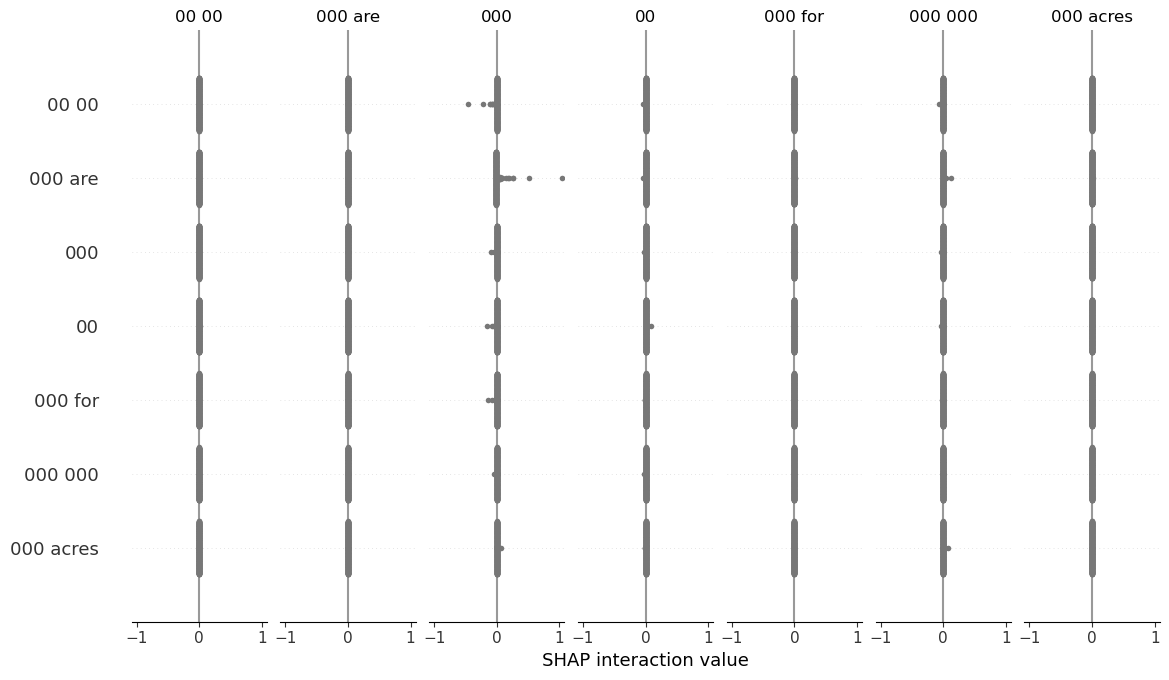

In [51]:
author_index = 0  # change this to any class index

shap.summary_plot(
    explainer.shap_values(x_test_tfidf),
    features=x_test_tfidf,
    feature_names=feature_names,
    class_names=le.classes_
)

This gives global explanations:

- Common stylistic markers
- Author-specific vocabulary

In [53]:
import numpy as np

# Pick a sample
sample_id = 0
sample_text = X_test.iloc[sample_id]
sample_vector = vectorizer.transform([sample_text])
# Predict class
pred_class = model.predict([sample_text])[0]
pred_class_name = le.inverse_transform([pred_class])[0]

print("Predicted author:", pred_class_name)

Predicted author: Charles Darwin


## Conclusion

This project successfully demonstrated an end-to-end Authorship Attribution System using Explainable Machine Learning techniques. Literary texts from Project Gutenberg were carefully curated to ensure reliable author metadata and sufficient samples per author. After preprocessing and exploratory data analysis, long documents were segmented into overlapping text chunks to capture stylistic patterns rather than content-specific cues.
A TF-IDF based Logistic Regression model was trained as a baseline classifier and achieved a strong accuracy of approximately 95%, indicating that lexical and phrase-level features are highly effective for authorship attribution. The model’s performance across multiple authors was stable, with balanced precision and recall, validating its generalization capability.

To enhance transparency and trustworthiness, SHAP (SHapley Additive exPlanations) was applied to interpret model predictions. Global SHAP explanations revealed the most influential stylistic features across authors, while local SHAP analyses highlighted specific words contributing to individual predictions. This explainability component ensures that the model’s decisions are interpretable and suitable for real-world applications.
Overall, the project provides a robust, interpretable, and scalable authorship attribution framework, making it suitable for applications such as plagiarism detection, forensic linguistics, and literary analysis.

## Importing into pickle file 

In [67]:
import pickle

# Save everything needed for inference
with open("authorship_model.pkl", "wb") as f:
    pickle.dump({
        "model": model,
        "label_encoder": le
    }, f)

print("✅ Model saved as authorship_model.pkl")

✅ Model saved as authorship_model.pkl
